In [1]:
import sys
sys.path.append('../code/functions')
from connectLib import otsuVox
from connectLib import clusterThresh
from plosLib import pipeline as PLOS
from random import randrange as rand
from cluster import Cluster
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
def neighborhoodDensity(data, interPlane = 1, intraPlane = 1, percentile = 50):
    output = np.zeros_like(data)
    for z in range(data.shape[0]):
        for y in range(data.shape[1]):
            for x in range(data.shape[2]):
                zLow = z-intraPlane
                zHigh = z+intraPlane
                yLow = y-interPlane
                yHigh = y+interPlane
                xLow = x-interPlane
                xHigh = x+interPlane
                if zLow>=0 and zHigh<data.shape[0] and yLow>=0 and yHigh<data.shape[1] and xLow>=0 and xHigh<data.shape[2]:
                    subVol = data[zLow:zHigh, yLow:yHigh, xLow:xHigh]
                    if not all(subVol.shape) == 0:
                        thresh = np.percentile(subVol, percentile)
                        binSubVol = subVol >= thresh
                        output[z][y][x] = (np.count_nonzero(binSubVol)/float(interPlane*interPlane*intraPlane)) * data[z][y][x] * np.average(subVol)
    return output

In [56]:
def generatePointSet():
    center = (rand(0, 9), rand(0, 999), rand(0, 999))
    toPopulate = []
    for z in range(-3, 2):
        for y in range(-3, 2):
            for x in range(-3, 2):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 1000:
                        valid = False
                if valid:
                    toPopulate.append(curPoint)
    return set(toPopulate)
    
def generateTestVolume():
    #create a test volume
    volume = np.zeros((10, 1000, 1000))
    myPointSet = set()
    for _ in range(rand(1000, 2000)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = rand(40000, 60000)
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    toPop = rand(0, 10)
                    if toPop == 5:
                        noiseVolume[z][y][x] = rand(0, 60000)
    return volume, noiseVolume

def generateDenseVolume(n):
    #create a test volume
    volume = np.zeros((10, 1000, 1000))
    myPointSet = set()
    for _ in range(n):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = rand(40000, 60000)
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    toPop = rand(0, 10)
                    if toPop == 5:
                        noiseVolume[z][y][x] = rand(0, 60000)
    return volume, noiseVolume

In [34]:
def f1score(trueClusterList, testClusterList):
    
    tp = 0
    fp = 0
    fn = 0
    
    testClusterTuples = []
    for elem in testClusterList:
        myTupleList = []
        members = elem.members
        for member in members:
            myTupleList.append(tuple(member))
        testClusterTuples.append(myTupleList)

    trueClusterTuples = []
    for elem in trueClusterList:
        myTupleList = []
        members = elem.members
        for member in members:
            myTupleList.append(tuple(member))
        trueClusterTuples.append(myTupleList)
    
    truePositives = []
    for testList in testClusterTuples:
        found = False
        for trueList in trueClusterTuples:
            if len(set(testList).intersection(set(trueList))) > 0:
                found = True
        if found:
            truePositives.append(testList)
            tp+=1
    
    fp = len(testClusterList) - tp
    fn = len(trueClusterList) - tp
    precision = float(tp)/float(fp+tp)
    recall = float(tp)/float(tp+fn)
    f1 = (2*precision*recall)/(precision+recall)
    
    return precision, recall, f1, truePositives, trueClusterTuples, testClusterTuples

# Gradient Generation Code

In [31]:
def applyGradient(volume, originX, originY):
    outStack = []
    maxDistance = np.sqrt((volume[0].shape[0])**2+(volume[0].shape[1])**2)
    for sample in volume:
        outSample = np.zeros_like(sample)
        for y in range(sample.shape[0]):
            for x in range(sample.shape[1]):
                distance = np.sqrt((x - originX)**2+(y - originY)**2)
                sigma = np.sqrt(distance)/np.sqrt(maxDistance)
                modifier = 1.-(sigma * distance/maxDistance)
                outSample[y][x] = modifier * sample[y][x]
        outStack.append(outSample)
    return np.stack(outStack)

# Gradient Sim

In [22]:
testGenVolLabel, testGenVol = generateTestVolume()

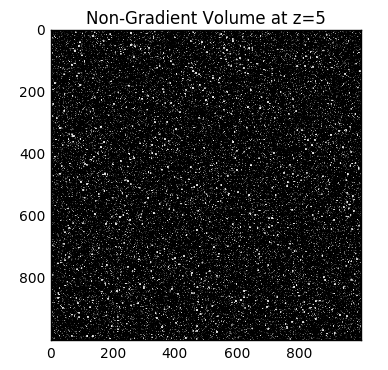

In [23]:
plt.figure()
plt.title('Non-Gradient Volume at z=5')
plt.imshow(testGenVol[5], cmap='gray')
plt.show()

In [32]:
testGenVolGrad = applyGradient(testGenVol, 0, 0)

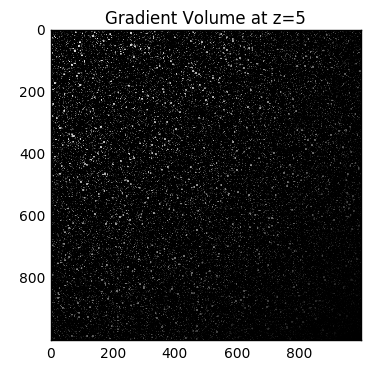

In [33]:
plt.figure()
plt.title('Gradient Volume at z=5')
plt.imshow(testGenVolGrad[5], cmap='gray')
plt.show()

# Simulation Code

In [40]:
statListG = []
statListN = []

def executeGradSim():
    testVol, noiseVol = generateTestVolume()
    gradVol = applyGradient(noiseVol, rand(0, noiseVol[0].shape[0]), rand(0, noiseVol[0].shape[1]))
    
    realSimN = neighborhoodDensity(noiseVol, 2, 2, 50)
    realSimNB = otsuVox(realSimN)
    realSimG = neighborhoodDensity(gradVol, 2, 2, 50)
    realSimGB = otsuVox(realSimG)
    
    clustersN = clusterThresh(realSimNB[4:6])
    clustersG = clusterThresh(realSimGB[4:6])
    clustersT = clusterThresh(testVol[4:6])
    
    precisionN, recallN, f1N, _, _, _ = f1score(clustersT, clustersN)
    precisionG, recallG, f1G, _, _, _ = f1score(clustersT, clustersG)
    
    print 'Non-Gradient:'
    print '\tPrecision: ', precisionN
    print '\tRecall: ', recallN
    print '\tf1: ', f1N

    print 'Gradient:'
    print '\tPrecision: ', precisionG
    print '\tRecall: ', recallG
    print '\tf1: ', f1G
    
    statListN.append([precisionN, recallN, f1N])
    statListG.append([precisionG, recallG, f1G])

In [41]:
executeGradSim()

Non-Gradient:
	Precision:  0.499167129373
	Recall:  0.991179713341
	f1:  0.663958641064
Gradient:
	Precision:  0.453043888627
	Recall:  1.05843439912
	f1:  0.634500991408


# Density Sim

In [44]:
testGenVolLabel, testGenVol = generateTestVolume()

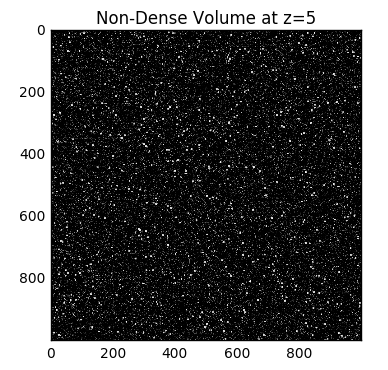

In [45]:
plt.figure()
plt.title('Non-Dense Volume at z=5')
plt.imshow(testGenVol[5], cmap='gray')
plt.show()

In [52]:
denseTestVol, denseNoiseVol = generateDenseVolume()

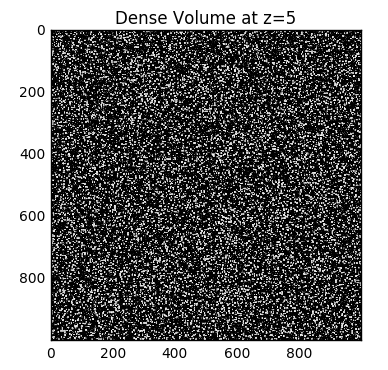

In [53]:
plt.figure()
plt.title('Dense Volume at z=5')
plt.imshow(denseNoiseVol[5], cmap='gray')
plt.show()

In [64]:
statListG = []
statListN = []

def executeDenseSim(n):
    testVol, noiseVol = generateTestVolume()
    denseTestVol, denseNoiseVol = generateDenseVolume(n)
    
    realSimN = neighborhoodDensity(noiseVol, 2, 2, 50)
    realSimNB = otsuVox(realSimN)
    realSimD = neighborhoodDensity(denseNoiseVol, 2, 2, 50)
    realSimDB = otsuVox(realSimD)
    
    clustersN = clusterThresh(realSimNB[4:6])
    clustersD = clusterThresh(realSimDB[4:6])
    
    clustersNT = clusterThresh(testVol[4:6])
    clustersDT = clusterThresh(denseTestVol[4:6])
    
    precisionN, recallN, f1N, _, _, _ = f1score(clustersNT, clustersN)
    precisionG, recallG, f1G, _, _, _ = f1score(clustersDT, clustersD)
    
    print 'Non-Dense:'
    print '\tPrecision: ', precisionN
    print '\tRecall: ', recallN
    print '\tf1: ', f1N

    print 'Dense:'
    print '\tPrecision: ', precisionG
    print '\tRecall: ', recallG
    print '\tf1: ', f1G
    
    statListN.append([precisionN, recallN, f1N])
    statListG.append([precisionG, recallG, f1G])
    return noiseVol, denseNoiseVol

In [65]:
nV, dnV = executeDenseSim(15000)

Non-Dense:
	Precision:  0.500896057348
	Recall:  0.986760812004
	f1:  0.664487369985
Dense:
	Precision:  0.506678759894
	Recall:  0.849813303831
	f1:  0.634846841262


In [66]:
nV, dnV = executeDenseSim(25000)

Non-Dense:
	Precision:  0.530487804878
	Recall:  0.984334203655
	f1:  0.689423956111
Dense:
	Precision:  0.460962833624
	Recall:  0.670780399274
	f1:  0.546422235364
